In [ ]:
""" 我们将从零开始实现整个方法, 包括数据流水线, 模型, 损失函数和小批量随机梯度下降优化器 """

In [46]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [47]:
# 根据带有噪声的线性模型构造一个人造数据集. 我们使用线性模型参数 w = [2, -3.4]T, b = 4.2 和噪声项e生成数据集及其标签: y = Xw + b + e
def synthetic_data(w, b, num_examples):
    """ 生成 y = Xw + b + 噪声 """
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [48]:
# features中的每一行都包含一个二维数据样本, labels中的每一行都包含一维标签值(一个标量)
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.1272, -1.4245]) 
label: tensor([8.7919])


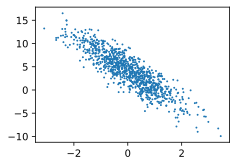

In [49]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1) 

In [50]:
# 定义一个 data_iter 函数, 该函数接收批量大小, 特征矩阵和标签向量作为输入, 生成大小为 batch_size 的小批量
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(0, num_examples))
    # 这些样本是随机读取的, 没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)]
        )
        yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break  # 只返回一个批次, 否则会重复100组

tensor([[ 0.8637,  2.2620],
        [ 1.3300, -0.1179],
        [ 0.2634, -0.1465],
        [ 1.5617, -1.2619],
        [ 1.4861, -2.2721],
        [ 1.6717,  1.1736],
        [-0.4472, -0.3517],
        [-0.7028, -0.6691],
        [-1.5627,  0.9150],
        [-0.4615, -0.4526]]) 
 tensor([[-1.7727],
        [ 7.2614],
        [ 5.2238],
        [11.6184],
        [14.9183],
        [ 3.5488],
        [ 4.4917],
        [ 5.0666],
        [-2.0185],
        [ 4.8210]])


In [51]:
# 初始化模型参数
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [52]:
# 定义模型
def linreg(X, w, b):
    """ 线性回归模型 """
    return torch.matmul(X, w) + b

In [53]:
# 定义损失函数
def squared_loss(y_hat, y):
    """ 均方损失 """
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

In [54]:
# 定义优化算法
def sgd(params, lr, batch_size):
    """ 小批量随机梯度下降 """
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [55]:
# 训练过程
lr = 0.03  # 学习率不能太大, 也不能太小
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.037237
epoch 2, loss 0.000137
epoch 3, loss 0.000051


In [56]:
# 比较真实参数和通过训练学到的参数来评估训练的成功程度
print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([0.0004, 0.0002], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0002], grad_fn=<RsubBackward1>)
